In [1]:
import glob
import warnings
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull

from PIL import Image
import matplotlib.pyplot as plt

from attacks import smote_detection_attack, smote_reconstruction_attack, check_collinear, calculate_scores

In [2]:
# !pip install Pillow

In [3]:
warnings.simplefilter("ignore", category=FutureWarning)

In [4]:
np.random.seed(42)

In [5]:
K = 3
SAMPLING_STRATEGY = 1

n_majority = 500
n_minority = 20

In [6]:
X = np.zeros((n_majority + n_minority, 2))
X[:n_majority] = np.random.multivariate_normal([0.5, 0.5], [[0.2, 0], [0, 0.2]], n_majority)
X[n_majority:] = np.random.multivariate_normal([-0.5, -0.5], [[0.2, 0], [0, 0.2]], n_minority)
y = np.concatenate((np.zeros(n_majority, int), np.ones(n_minority, int)))

X_real_majority = X[:n_majority]
X_real_minority = X[n_majority:]

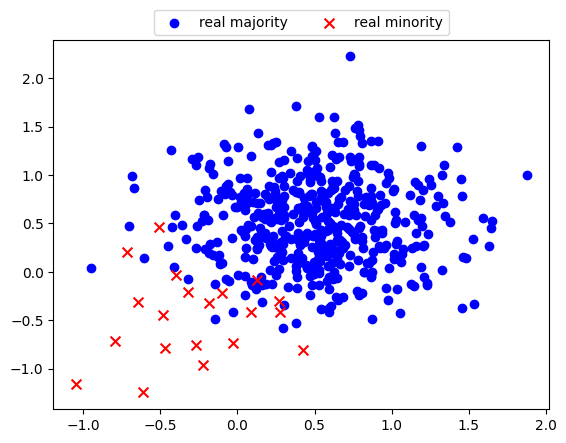

In [7]:
plt.scatter(X_real_majority[:, 0], X_real_majority[:, 1], marker='o', c="b", label="real majority")
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], marker='x', c="r", s=50, label="real minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))
plt.show()

In [8]:
generator = SMOTE(k_neighbors=K, sampling_strategy=SAMPLING_STRATEGY, random_state=42)
X_augmented, y_augmented = generator.fit_resample(X, y)

X_augmented_minority = X_augmented[y_augmented==1]
X_synthetic = X_augmented[len(y):]
y_synthetic = y_augmented[len(y):]

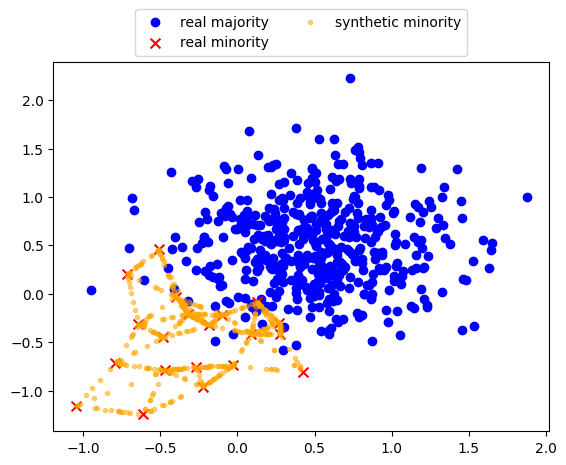

In [9]:
plt.scatter(X_real_majority[:, 0], X_real_majority[:, 1], marker='o', c="b", label="real majority")
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], marker='x', c="r", s=50, label="real minority")
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

In [10]:
tree = NearestNeighbors(n_neighbors=K+1).fit(X_real_minority)

lines = {}
for i in range(len(X_real_minority)):
    nbs = tree.kneighbors(X_real_minority[i].reshape(1, -1), return_distance=False)[0]
    for j in nbs:
        line = (min(i, j), max(i, j))
        if j == i or line in lines:
            continue
        lines[line] = [X_real_minority[i], X_real_minority[j]]

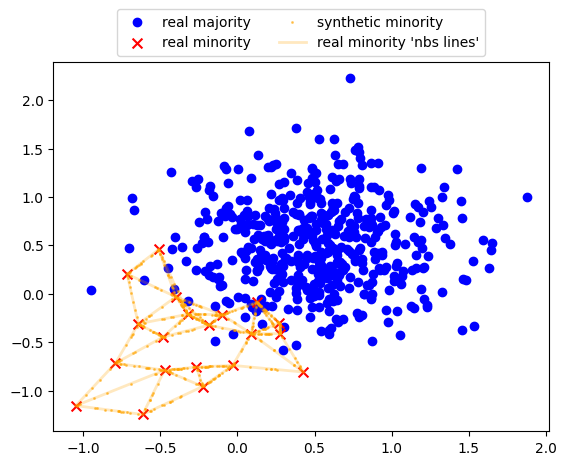

In [11]:
plt.scatter(X_real_majority[:, 0], X_real_majority[:, 1], marker='o', c="b", label="real majority")
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], marker='x', c="r", s=50, label="real minority")
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", s=5, alpha=0.5, label="synthetic minority")
for i, line in enumerate(lines.values()):
    if not i:
        plt.plot((line[0][0], line[1][0]), (line[0][1], line[1][1]), c="orange", alpha=0.25, linewidth=2, label="real minority 'nbs lines'")
    else:    
        plt.plot((line[0][0], line[1][0]), (line[0][1], line[1][1]), c="orange", alpha=0.25, linewidth=2)
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()


In [12]:
hull = ConvexHull(X_augmented_minority)

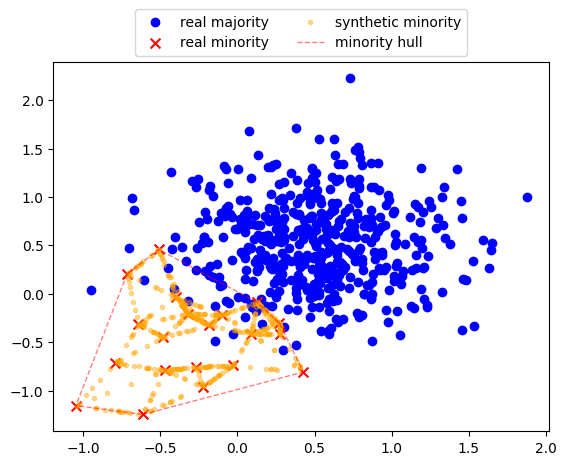

In [13]:
plt.scatter(X_real_majority[:, 0], X_real_majority[:, 1], marker='o', c="b", label="real majority")
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], marker='x', c="r", s=50, label="real minority")
plt.scatter(X_augmented[n_majority+n_minority:, 0], X_augmented[n_majority+n_minority:, 1], marker='.', c="orange", alpha=0.4, label="synthetic minority")
for i, simplex in enumerate(hull.simplices):
    if not i:
        plt.plot(X_augmented_minority[simplex, 0], X_augmented_minority[simplex, 1], 'r--', linewidth=1, alpha=0.5, label="minority hull")
    else:  
        plt.plot(X_augmented_minority[simplex, 0], X_augmented_minority[simplex, 1], 'r--', linewidth=1, alpha=0.5)
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

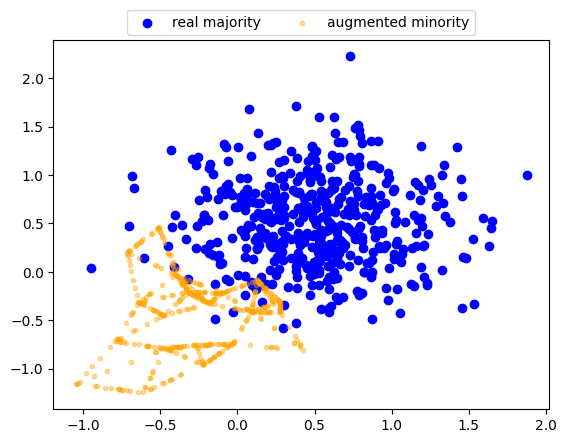

In [14]:
plt.scatter(X_real_majority[:, 0], X_real_majority[:, 1], marker='o', c="b", label="real majority")
plt.scatter(X_augmented_minority[:, 0], X_augmented_minority[:, 1], marker='.', c="orange", alpha=0.4, label="augmented minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))

plt.show()

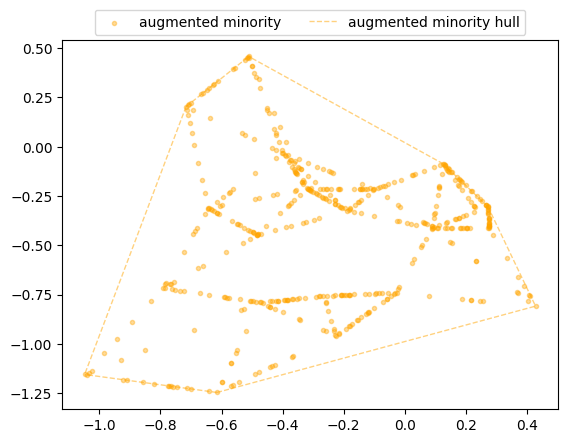

In [15]:
plt.scatter(X_augmented_minority[:, 0], X_augmented_minority[:, 1], marker='.', c="orange", alpha=0.4, label="augmented minority")
for i, simplex in enumerate(hull.simplices):
    if not i:
        plt.plot(X_augmented_minority[simplex, 0], X_augmented_minority[simplex, 1], '--', c="orange", linewidth=1, alpha=0.5, label="augmented minority hull")
    else:  
        plt.plot(X_augmented_minority[simplex, 0], X_augmented_minority[simplex, 1], '--', c="orange", linewidth=1, alpha=0.5)
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))

plt.show()

In [16]:
X_minority_unique = np.unique(X_real_minority, axis=0)

N = len(X_minority_unique)
noncollinear_mask = np.zeros(N, dtype=bool)
for i in range(N):
    if noncollinear_mask[i]:
        continue

    for j in range(i+1, N):
        if noncollinear_mask[j]:
            continue

        for k in range(j+1, N):
            a, b, c = X_minority_unique[i], X_minority_unique[j], X_minority_unique[k]
            noncollinear_mask[k] = check_collinear(a, b, c)
X_minority_unique_noncoll = X_minority_unique[~noncollinear_mask]

print(f"""N minority -- {len(X_real_minority)}, """
      f"""N minority unique -- {len(X_minority_unique)}, """
      f"""N minority unique noncollinear -- {len(X_minority_unique_noncoll)}""")

N minority -- 20, N minority unique -- 20, N minority unique noncollinear -- 20


In [17]:
r = (y_augmented == 1).sum() / (y == 1).sum()

detected_real_minority, history = smote_detection_attack(X_augmented, y_augmented, k=K, r=r, return_details=True)
precision, recall, f1 = calculate_scores(X, y, detected_real_minority)
print(f"Detection Attack: precision -- {precision}, recall -- {recall}, f1 -- {f1}")

Detection Attack: precision -- 1.0, recall -- 1.0, f1 -- 1.0


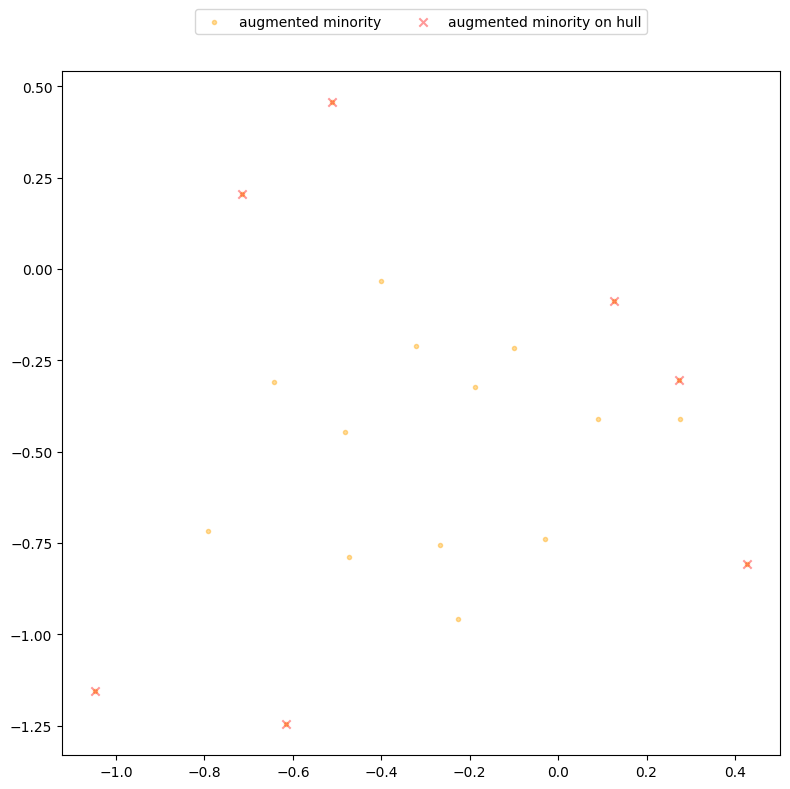

In [ ]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(X_augmented_minority[:, 0], X_augmented_minority[:, 1], marker='.', c="orange", alpha=0.4, label="augmented minority")
plt.scatter(X_augmented_minority[hull.vertices, 0], X_augmented_minority[hull.vertices, 1], marker='x', c="red", alpha=0.4, label="augmented minority on hull")
plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig('results/plots/gifs/detect/gif_00_0.png', dpi=fig.dpi)
for i_idx, (i, i_dict) in enumerate(history):
    plt.scatter(X_augmented_minority[i, 0], X_augmented_minority[i, 1], marker='X', c="black", alpha=1, s=150, label="current record in queue")
    plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/detect/gif_{i_idx:02d}_1.png', dpi=fig.dpi)
    plt.scatter(X_augmented_minority[i_dict["nbs"], 0], X_augmented_minority[i_dict["nbs"], 1], marker='.', c="grey", alpha=0.75, s=100, label="nbs of current record")
    plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/detect/gif_{i_idx:02d}_2.png', dpi=fig.dpi)
    plt.scatter(X_augmented_minority[list(i_dict.get("to_remove", [])), 0], X_augmented_minority[list(i_dict.get("to_remove", [])), 1], marker='.', c="purple", alpha=0.75, s=100, label="nbs to remove")
    plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/detect/gif_{i_idx:02d}_3.png', dpi=fig.dpi)
    plt.clf()
    plt.scatter(X_augmented_minority[i_dict["candidate_mask"], 0], X_augmented_minority[i_dict["candidate_mask"], 1], marker='.', c="orange", alpha=0.4, label="augmented minority")
    plt.scatter(X_augmented_minority[hull.vertices, 0], X_augmented_minority[hull.vertices, 1], marker='x', c="red", alpha=0.4, label="augmented minority on hull")
    plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/detect/gif_{i_idx:02d}_4.png', dpi=fig.dpi)
plt.show()

In [ ]:
frames = []
for filename in sorted(glob.glob('results/plots/gifs/detect/*.png')):
    im = Image.open(filename)
    im_small = im.resize((800, 800), resample=0)
    frames.append(im_small)

frame_one = frames[0]
last_frame = frames[-1]
for _ in range(10):
    frames.append(last_frame)

# frame_one.save('results/plots/gifs/detect.gif', format="GIF", append_images=frames,
#                save_all=True, duration=1000, loop=0)    

In [ ]:
reconstructed_points, (lines, lines_midpoints, lines_intersections) = smote_reconstruction_attack(X_synthetic, y_synthetic, k=K, r=r, return_details=True)
precision, recall, f1 = calculate_scores(X, y, reconstructed_points, line_eps=1e-12, exact_match=False)
print(f"Reconstruction Attack: precision -- {precision}, recall -- {recall}, f1 -- {f1}")

Reconstruction Attack: precision -- 1.0, recall -- 1.0, f1 -- 1.0


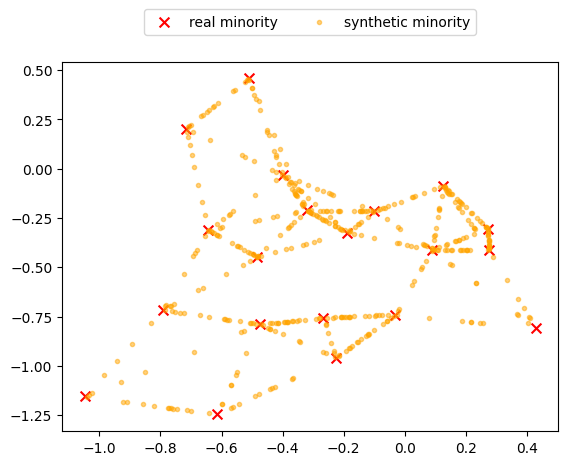

In [21]:
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], marker='x', c="r", s=50, label="real minority")
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

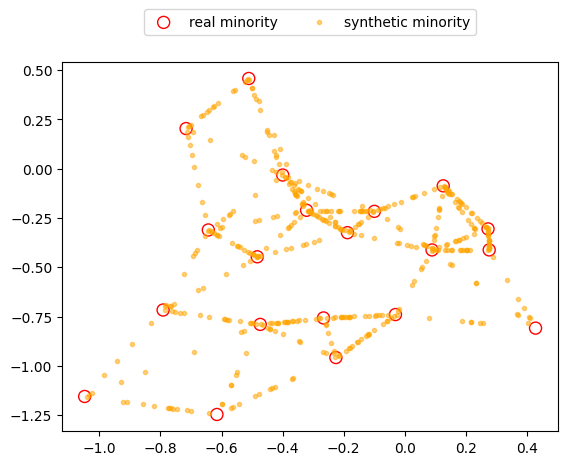

In [22]:
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], facecolors='none', edgecolors='r', s=75, label="real minority")
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

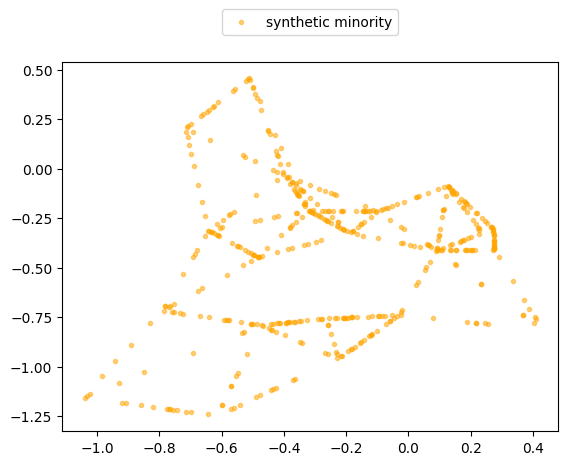

In [23]:
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

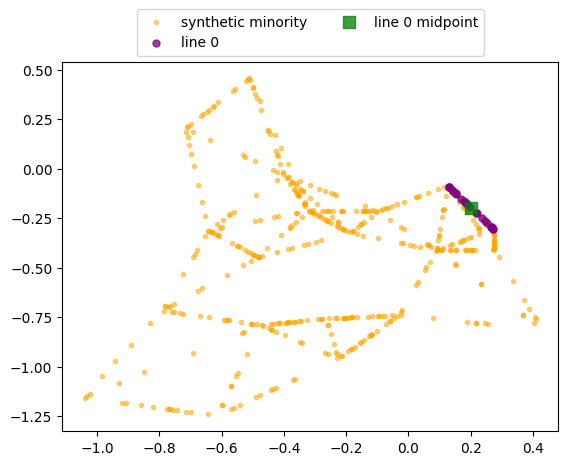

In [24]:
line_idx = 0

plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="purple", alpha=0.75, s=100, label=f"line {line_idx}")
plt.scatter(lines_midpoints[line_idx][0], lines_midpoints[line_idx][1], marker='s', c="green", alpha=0.75, s=75, label=f"line {line_idx} midpoint")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

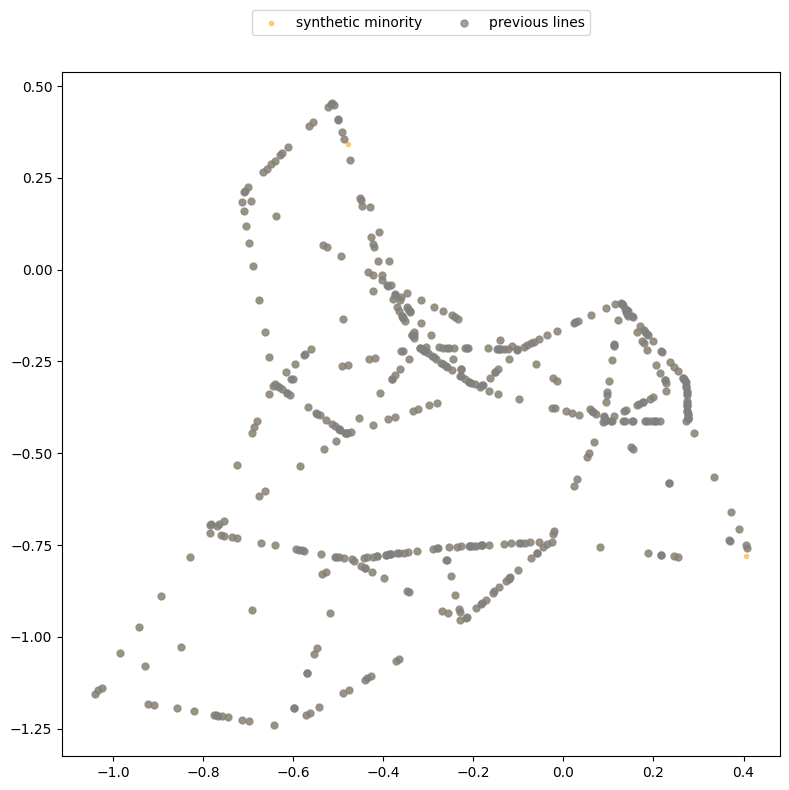

In [ ]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig('results/plots/gifs/recon_lines/gif_00.png', dpi=fig.dpi)

line_idx = 0
line_ax = plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="purple", alpha=0.75, s=100, label=f"line {line_idx}")
midpoint_ax = plt.scatter(lines_midpoints[line_idx][0], lines_midpoints[line_idx][1], marker='s', c="green", alpha=0.75, s=75, label=f"line {line_idx} midpoint")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig('results/plots/gifs/recon_lines/gif_01.png', dpi=fig.dpi)

for line_idx in range(1, len(lines)):
    line_ax.remove()
    midpoint_ax.remove()
    if line_idx == 1:
        plt.scatter(X_synthetic[list(lines[line_idx-1]), 0], X_synthetic[list(lines[line_idx-1]), 1], marker='.', c="gray", alpha=0.75, s=100, label="previous lines")
    else:
        plt.scatter(X_synthetic[list(lines[line_idx-1]), 0], X_synthetic[list(lines[line_idx-1]), 1], marker='.', c="gray", alpha=0.75, s=100)
    line_ax = plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="purple", alpha=0.75, s=100, label=f"line {line_idx}")
    midpoint_ax = plt.scatter(lines_midpoints[line_idx][0], lines_midpoints[line_idx][1], marker='s', c="green", alpha=0.75, s=75, label=f"line {line_idx} midpoint")
    plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/recon_lines/gif_{line_idx + 1:02d}.png', dpi=fig.dpi)

line_ax.remove()
midpoint_ax.remove()
plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="gray", alpha=0.75, s=100)
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig(f'results/plots/gifs/recon_lines/gif_{line_idx + 1:02d}.png', dpi=fig.dpi)

plt.show()

In [ ]:
frames = []
for filename in sorted(glob.glob('results/plots/gifs/recon_lines/*.png')):
    im = Image.open(filename)
    im_small = im.resize((800, 800), resample=0)
    frames.append(im_small)

frame_one = frames[0]
last_frame = frames[-1]
for _ in range(10):
    frames.append(last_frame)

# frame_one.save('results/plots/gifs/recon_lines.gif', format="GIF", append_images=frames,
#                save_all=True, duration=700, loop=0)    

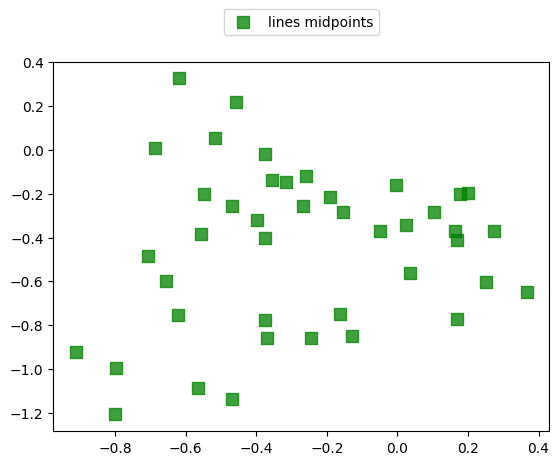

In [32]:
plt.scatter(lines_midpoints[:, 0], lines_midpoints[:, 1], marker='s', c="green", alpha=0.75, s=75, label=f"lines midpoints")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()

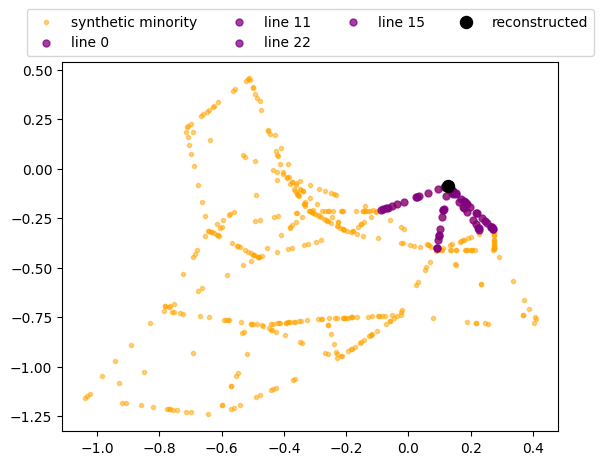

In [28]:
intersect_idx = 0
intersect_lines = lines_intersections[intersect_idx]
intersect_lines = list(set([line for tup in intersect_lines for line in tup]))

plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
for line_idx in intersect_lines:
    plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="purple", alpha=0.75, s=100, label=f"line {line_idx}")
plt.scatter(reconstructed_points[intersect_idx][0], reconstructed_points[intersect_idx][1], marker='.', c="black", alpha=1, s=300, label=f"reconstructed")

plt.legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5, 1.16))
plt.show()

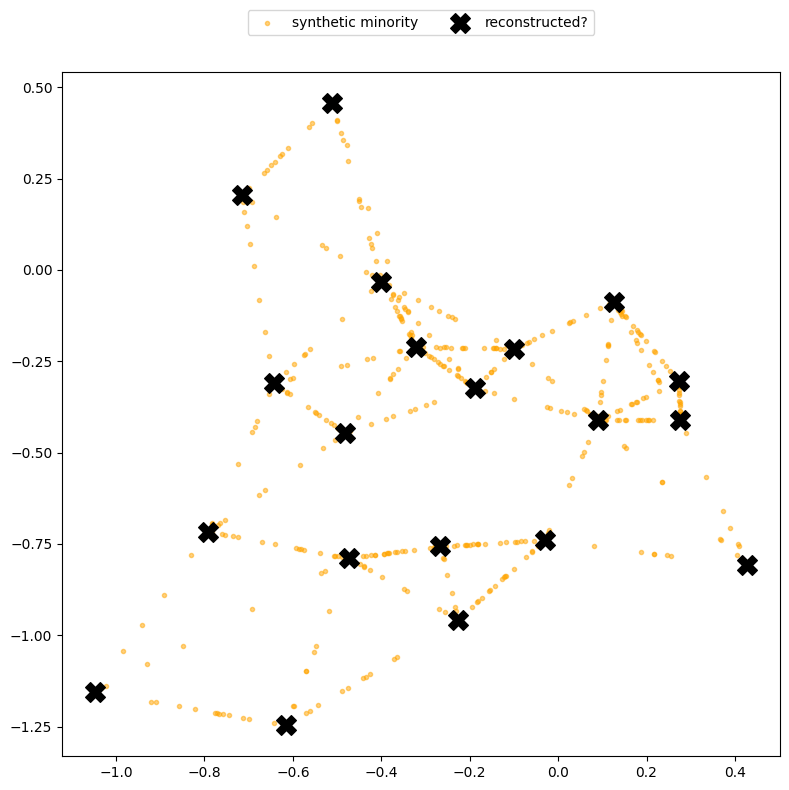

In [ ]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig('results/plots/gifs/recon_inter/gif_00.png', dpi=fig.dpi)

for intersect_idx in range(len(lines_intersections)):
    intersect_lines = lines_intersections[intersect_idx]
    intersect_lines = list(set([line for tup in intersect_lines for line in tup]))
    
    rec_ax = plt.scatter(reconstructed_points[intersect_idx][0], reconstructed_points[intersect_idx][1], marker='X', c="black", alpha=1, s=200, label=f"reconstructed?")
    axes = []
    for line_idx in intersect_lines:
        axes.append(plt.scatter(X_synthetic[list(lines[line_idx]), 0], X_synthetic[list(lines[line_idx]), 1], marker='.', c="purple", alpha=0.75, s=100, label=f"line {line_idx}"))

    plt.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.5, 1.1))
    plt.tight_layout()
    # fig.savefig(f'results/plots/gifs/recon_inter/gif_{intersect_idx + 1:02d}.png', dpi=fig.dpi)

    for ax_id in range(len(axes)):
        axes[ax_id].remove()
    rec_ax.remove()

plt.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1], marker='X', c="black", alpha=1, s=200, label=f"reconstructed?")
plt.legend(loc="upper center", ncols=5, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
# fig.savefig(f'results/plots/gifs/recon_inter/gif_{intersect_idx + 2:02d}.png', dpi=fig.dpi)
plt.show()

In [ ]:
frames = []
for filename in sorted(glob.glob('results/plots/gifs/recon_inter/*.png')):
    im = Image.open(filename)
    im_small = im.resize((800, 800), resample=0)
    frames.append(im_small)

frame_one = frames[0]
last_frame = frames[-1]
for _ in range(10):
    frames.append(last_frame)

# frame_one.save('results/plots/gifs/recon_inter.gif', format="GIF", append_images=frames,
#                save_all=True, duration=1000, loop=0)    

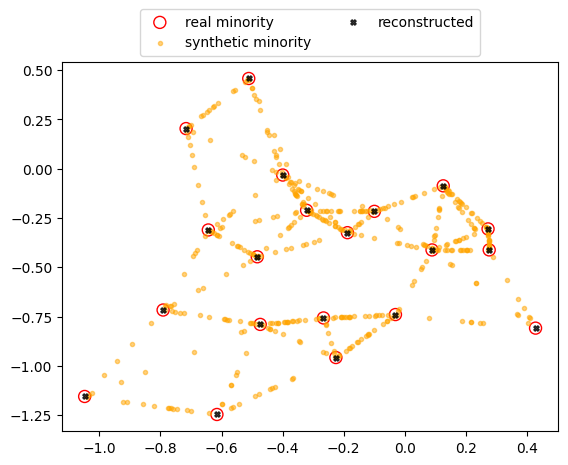

In [31]:
plt.scatter(X_real_minority[:, 0], X_real_minority[:, 1], facecolors='none', edgecolors='r', s=75, label="real minority")
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], marker='.', c="orange", alpha=0.5, label="synthetic minority")
plt.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1], marker='X', c="black", alpha=0.75, s=15, label="reconstructed")
plt.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.16))
plt.show()